In [1]:
from tabnanny import verbose
from utils import prepare_data_gaussian, prepare_data_news, plot_result
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

import numpy as np
import cvxpy as cp

np.random.seed(1)

In [2]:
data_news,dataset = prepare_data_news(),0  #alpha = 0.01 for task1,alpha = 1 for task2,lr = 0.001, adaptiv,LR 0.001
#data_news, dataset = prepare_data_gaussian(),1 #alpha = 0.01 for task1, alpha = ALPHA 0.01 for task2, 0.025 learning rate

In [3]:
class MyRegressor:
    def __init__(self, alpha, lr = 0.01):
        self.weight = None
        self.bias = None
        self.training_cost = 0   # N * M
        self.alpha = alpha
        self.selectedColumns  = None # selected features indices from Task 1.3
        self.learningRate = lr #learning rate parameter for online learning
        self.communicationCostRatio = None #Final cost ratio of online learning
        
    # trainX, data that will be used in training
    # trainY, labels that will be used in training
    # selectRatio [0-1], specifies the number of features to be selected. 0.5 --> 50%
    def select_features(self,trainX, trainY,selectRatio): 
        ''' Task 1-3'''

        m = trainX.shape[1]
        
        self.train(trainX,trainY)
        
        id_c = np.argsort(self.weight) # you need to get weight vector
        id_c = id_c[::-1]
        self.selectedColumns = id_c[:int(np.ceil(m*selectRatio))]
        
        return self.selectedColumns # The index List of selected features
        
    # trainX, data that will be used in training
    # trainY, labels that will be used in training
    # selectRatio [0-1], specifies the number of features to be selected. 0.5 --> 50%    
    def select_sample(self, trainX, trainY,selectRatio):
        ''' Task 1-4 '''
        m = trainX.shape[1] # features
        n = trainX.shape[0] # samples
        num_samples = int(np.ceil(m*selectRatio))

        self.train(trainX,trainY)
        loss = abs(trainY - (trainX @ self.weight + self.bias * np.ones((n))))
        num_samples = int(np.ceil(n*selectRatio))
        idx = np.argsort(loss)
        rows = idx[0:num_samples]
        selected_trainX = trainX[rows,:]
        selected_trainY = trainY[rows]
  
            
        return selected_trainX,  selected_trainY   # A subset of trainX and trainY

    # trainX, data that will be used in training
    # trainY, labels that will be used in training
    # selectRatio [0-1], specifies the number of samples to be selected. 0.5 --> 50% 
    def select_data(self, trainX, trainY, selectRatio):
        ''' Task 1-5 '''
        cost_selectRatio = np.sqrt(selectRatio)
        selectedColumns = self.select_features(trainX,trainY,cost_selectRatio)
        selected_trainX,selected_trainY = self.select_sample(trainX[:,selectedColumns],trainY,cost_selectRatio)
        
        return selected_trainX, selected_trainY
    
    # trainX, data that will be used in training
    # trainY, labels that will be used in training
    def train(self, trainX, trainY):
        ''' Task 1-2 '''
        self.weight = None
        self.bias = None
        self.training_cost = 0
        
        n = trainX.shape[0] # samples, row
        m = trainX.shape[1] # features, column
        trainY = trainY.reshape(-1,1)
        t = cp.Variable((n,1))
        z = cp.Variable((m,1))
        weight = cp.Variable((m,1))
        bias = cp.Variable((1))
        objective  = cp.Minimize(((1/n)*(np.ones((n,1)).T @ t)) + self.alpha *(np.ones((m,1)).T @ z))
        constraints = [trainY -(trainX @ weight + bias * np.ones((n,1))) <= t,
                      -trainY +(trainX @ weight + bias * np.ones((n,1))) <= t,
                       weight <= z, 
                        -weight <= z]
            
        prob = cp.Problem(objective, constraints)
        prob.solve()
        print("status: {}".format(prob.status))
        self.weight = weight.value.flatten()
        self.bias = bias.value.flatten()
        self.training_cost = n * m

        trainY = trainY.flatten()    
        predY,train_error = self.evaluate(trainX,trainY)

        return train_error
    
    # trainX, data that will be used in online training
    # trainY, labels that will be used in online training
    # communication_cost_ratio, required communication_cost_ratio constraint to be hold at any time
    def train_online(self, trainX, trainY, communication_cost_ratio):
        ''' Task 2 '''
        m = trainX.shape[1]
        theta = np.zeros((m))
        bias = 0
        
        communication_cost_sent = 0
        communication_cost_received = 0

        clf = SGDRegressor( loss='epsilon_insensitive', penalty='l1', alpha = self.alpha , 
                           epsilon = 0, learning_rate = 'adaptive', eta0 = self.learningRate)
        losses = []
        count_skipped = 0
        buffer_last_index = 0
        for index, x in enumerate(trainX):
        
            m = trainX.shape[1]
            y = trainY[index] # scalar x is 1d array with size m(features)
    
            if index == 0:
                sensorX = np.array(np.array(x).reshape(1,-1))
                sensorY = np.array(y).reshape(1)
            else:
                sensorX = np.append(sensorX, x.reshape(1,-1),axis = 0)
                sensorY = np.append(sensorY,y)
    
            communication_cost_received += 1*x.shape[0] 
        
            sensor_sample_x = sensorX[buffer_last_index,:]
            sensor_sample_y = sensorY[buffer_last_index]

            x_row = sensor_sample_x.reshape(1,-1) # Row vector 1x500
            y_row = sensor_sample_y.reshape(1) # row vector 1

        
            if(communication_cost_sent / communication_cost_received <= communication_cost_ratio):
                buffer_last_index += 1
                if index >= int(np.ceil(m*10)): #Tuneable
                    y_pred_before = x_row @ theta + bias
                    loss_before = np.abs(y_row-y_pred_before)
                    Z_score = np.abs((loss_before - np.mean(losses))/np.std(losses))
                    if Z_score < 2: #Tuneable
                        if buffer_last_index == 1:
                            nodeX = x_row
                            nodeY = y_row
                        else:
                            nodeX = np.append(nodeX, x_row,axis = 0)
                            nodeY = np.append(nodeY, y_row)
                         
                        if buffer_last_index >= 100:  #Tuneable
                            truncated_theta = []
                            selectedFeatureIndices = []
                            for j in range(theta.shape[0]):
                                if(theta[j] != 0 and np.abs(theta[j]) > 10**-5): # Tuneable
                                    truncated_theta.append(theta[j])
                                    selectedFeatureIndices.append(j)

                                    x_selectedFeature_row = x_row[:,np.array(selectedFeatureIndices)]
                        else:
                            x_selectedFeature_row = x_row
                        
                        communication_cost_sent += 1*x_selectedFeature_row.shape[1]
                        clf.partial_fit(x_row, y_row)
                        theta = clf.coef_.flatten()
                        bias  = clf.intercept_
                        y_pred_after = x_row @ theta + bias
                        loss_after = np.abs(y_row-y_pred_after)
                        losses.append(loss_after)
                
                    else:
                        count_skipped+=1
                else:
                    if buffer_last_index == 1:
                        nodeX = x_row
                        nodeY = y_row
                    else:
                        nodeX = np.append(nodeX, x_row,axis = 0)
                        nodeY = np.append(nodeY, y_row)
                    
                    if buffer_last_index >= 100: #Tuneable
                        truncated_theta = []
                        selectedFeatureIndices = []
                        for j in range(theta.shape[0]):
                            if(theta[j] != 0 and np.abs(theta[j]) > 10**-5):
                                truncated_theta.append(theta[j])
                                selectedFeatureIndices.append(j)
                        x_selectedFeature_row = x_row[:,np.array(selectedFeatureIndices)]
                    else:
                        x_selectedFeature_row = x_row
                    
                    communication_cost_sent += 1*x_selectedFeature_row.shape[1]
                    clf.partial_fit(x_row, y_row)
                    theta = clf.coef_.flatten()
                    bias  = clf.intercept_
                    y_pred_after = x_row @ theta + bias
                    loss_after = np.abs(y_row-y_pred_after)
                    losses.append(loss_after)
        self.weight = theta
        self.bias = bias
        self.communicationCostRatio = communication_cost_sent / communication_cost_received
        Y_pred = nodeX @ theta + bias
        train_error = mean_absolute_error(nodeY,Y_pred)
        
        self.training_cost = communication_cost_sent
        return self.training_cost, train_error

    
    def evaluate(self, X, Y):
        predY = X @ self.weight + self.bias
        error = mean_absolute_error(Y, predY)
        
        return predY, error
    
    def test(self, X, Y):
        predY = X @ self.weight + self.bias
        error = mean_absolute_error(Y, predY)
        
        return predY, error
    
    def get_params(self):
        return self.weight, self.bias

In [4]:
## Sample Experiment for Task 1-2 ##################### DONE
result_1_2 = {'taskID':'1-2', 'alpha':[], 'train_err':[], 'test_err':[]}
alpha_s = [0,10**-10,10**-5,10**-4, 10**-2, 10**-1,10**0, 10**1,10**2,10**5]
for i in range(len(alpha_s)):
    alpha = alpha_s[i]
    model = MyRegressor(alpha=alpha)

    trainX = data_news['trainX']
    trainY = data_news['trainY']
    testX = data_news['testX']
    testY = data_news['testY']
        
    train_err = model.train(trainX, trainY)
    _, test_err = model.test(testX, testY)
    
    result_1_2['alpha'].append(alpha)
    result_1_2['train_err'].append(train_err)
    result_1_2['test_err'].append(test_err)


status: optimal


C:\Users\yaman\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


status: optimal_inaccurate
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal


In [5]:
## Sample Experiment for Task 1-3 ##################### DONE
selectRatio_s = [0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]


alpha = 10**-2
result_1_3 = {'taskID':'1-3', 'feat_num':[], 'train_err':[], 'test_err':[]}
for i in range(len(selectRatio_s)):
    
    model = MyRegressor(alpha=alpha)
    trainX = data_news['trainX']
    trainY = data_news['trainY']
    testX = data_news['testX']
    testY = data_news['testY']
    
    selectRatio = selectRatio_s[i]
    selectedColumns = model.select_features(trainX,trainY,selectRatio)
    train_err = model.train(trainX[:,selectedColumns], trainY)
    _, test_err = model.test(testX[:,selectedColumns], testY)
    
    result_1_3['feat_num'].append(selectRatio)
    result_1_3['train_err'].append(train_err)
    result_1_3['test_err'].append(test_err)


status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal


In [6]:
## Sample Experiment for Task 1-4
selectRatio_s = [0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]
result_1_4 = {'taskID':'1-4', 'sample_num':[], 'train_err':[], 'test_err':[]}
for i in range(len(selectRatio_s)):
    alpha = 10**-2
    
    model = MyRegressor(alpha=alpha)
    trainX = data_news['trainX']
    trainY = data_news['trainY']
    testX = data_news['testX']
    testY = data_news['testY']
    
    selectRatio = selectRatio_s[i]
    
    trainX_sampleReduced,trainY_sampleReduced = model.select_sample(trainX,trainY,selectRatio)

    train_err = model.train(trainX_sampleReduced, trainY_sampleReduced)
    _, test_err = model.test(testX, testY)
    
    result_1_4['sample_num'].append(selectRatio)
    result_1_4['train_err'].append(train_err)
    result_1_4['test_err'].append(test_err)

status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal


In [7]:
## Sample Experiment for Task 1-5

selectRatio_s = [0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]
result_1_5 = {'taskID':'1-5', 'cost':[], 'train_err':[], 'test_err':[]}

for i in range(len(selectRatio_s)):
    alpha = 10**-2
    
    model = MyRegressor(alpha=alpha)
    trainX = data_news['trainX']
    trainY = data_news['trainY']
    testX = data_news['testX']
    testY = data_news['testY']
    
    selectRatio = selectRatio_s[i]
    
    trainX_sizeReduced,trainY_sizeReduced = model.select_data(trainX, trainY, selectRatio)
    
    train_err = model.train(trainX_sizeReduced, trainY_sizeReduced)
    _, test_err = model.test(testX[:,model.selectedColumns], testY)
    
    result_1_5['cost'].append(selectRatio)
    result_1_5['train_err'].append(train_err)
    result_1_5['test_err'].append(test_err)


status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal


In [8]:
## Sample Experiment for Task 2
communicationCostRatio_s = [0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]
result_2 = {'taskID':'2', 'cost':[], 'train_err':[], 'test_err':[]}
for i in range(len(communicationCostRatio_s)):
    alpha = 10**-2
    if dataset == 0:
        lr = 0.01
    elif dataset == 1:
        lr = 0.025
    else:
        lr = 0.01
        
    model = MyRegressor(alpha=alpha,lr = lr)
    trainX = data_news['trainX']
    trainY = data_news['trainY']
    testX = data_news['testX']
    testY = data_news['testY']  

    cost,train_err = model.train_online(trainX, trainY,communicationCostRatio_s[i])
    _,test_err = model.test(testX, testY)

    result_2['cost'].append(model.communicationCostRatio)
    result_2['train_err'].append(train_err)
    result_2['test_err'].append(test_err)

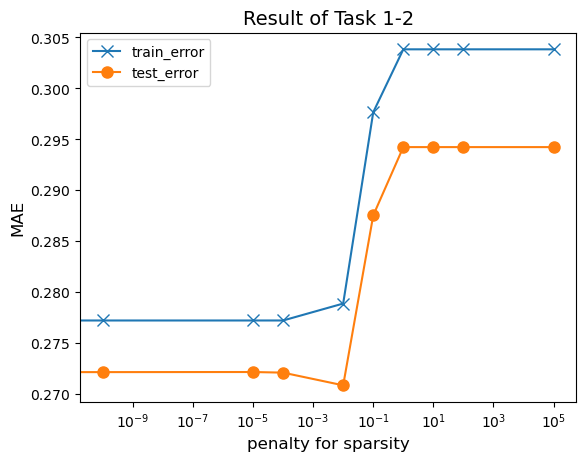

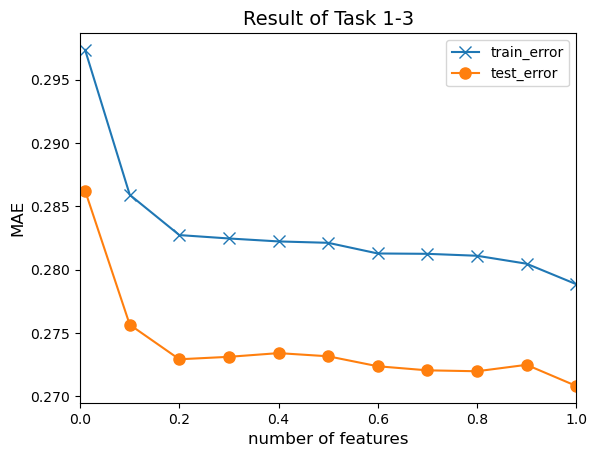

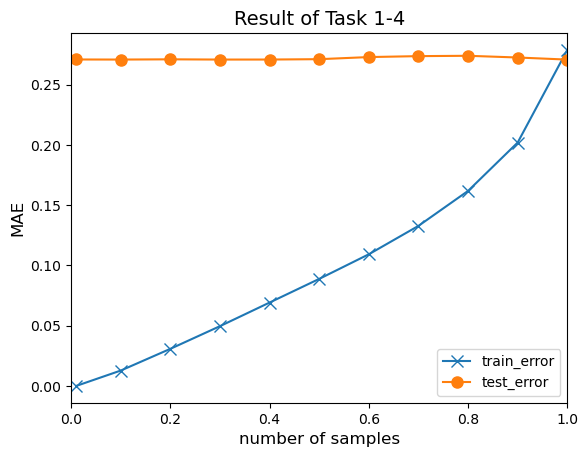

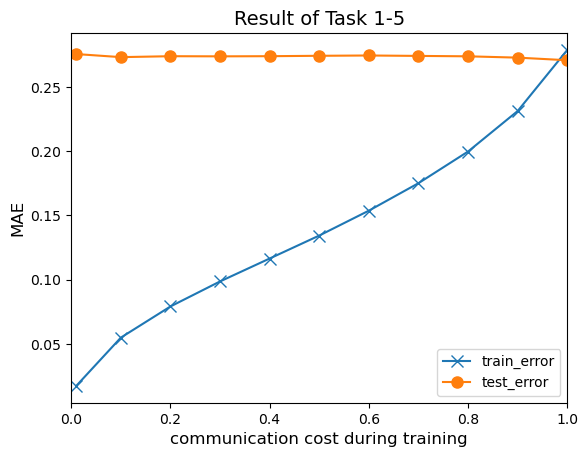

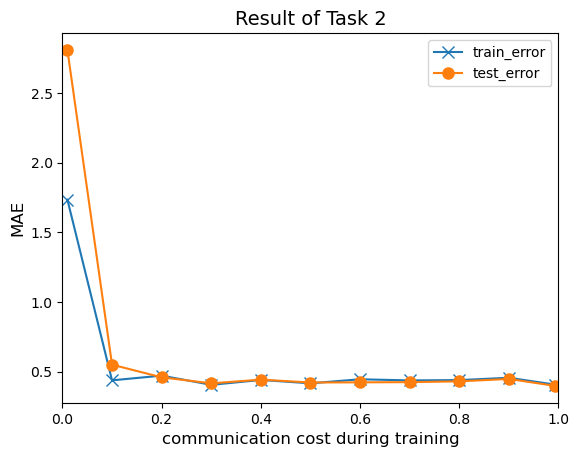

In [9]:
plot_result(result_1_2)
plot_result(result_1_3)
plot_result(result_1_4)
plot_result(result_1_5)
plot_result(result_2)